In [8]:
import psycopg2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [14]:
conn = psycopg2.connect(
    database="DVD database",
    user="postgres",
    password="thomas612",
    host="127.0.0.1",
    port="5432"
)

# Execute the query and read the results into a DataFrame
df = pd.DataFrame(pd.read_sql_query(
    'SELECT * FROM film',
    conn))

C:\Users\lamma\AppData\Roaming\Python\Python39\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


## 1. Create a time-series plot showing daily total revenue for three different countries with three countries in one plot (you will want matplotlib for this)


In [39]:
df = pd.DataFrame(pd.read_sql_query(
    'SELECT '
    'cy.country, '
    'SUM(p.amount) as sales_amount, '
    'DATE(p.payment_date) as payment_date '
    'FROM payment p '
    'LEFT JOIN customer c ON p.customer_id = c.customer_id '
    'LEFT JOIN address a ON a.address_id = c.address_id '
    'LEFT JOIN city ct ON ct.city_id = a.city_id '
    'LEFT JOIN country cy ON cy.country_id = ct.country_id '
    'GROUP BY cy.country, p.amount, DATE(p.payment_date) '
    'ORDER BY DATE(p.payment_date) ASC;',
    conn))

C:\Users\lamma\AppData\Roaming\Python\Python39\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [40]:
df

,country,sales_amount,payment_date
0,Austria,2.99,2007-02-14
1,Cambodia,4.99,2007-02-14
2,China,1.99,2007-02-14
3,China,5.98,2007-02-14
4,Egypt,7.99,2007-02-14
...,...,...,...
7270,Vietnam,0.99,2007-05-14
7271,Vietnam,2.99,2007-05-14
7272,Vietnam,4.99,2007-05-14
7273,Yemen,2.99,2007-05-14


In [42]:
df['payment_date'] = pd.to_datetime(df['payment_date'])

In [54]:
grouped_df = df.groupby(['payment_date', 'country'])['sales_amount'].sum().reset_index()

In [55]:
sorted_df = grouped_df.sort_values('sales_amount', ascending=False)

In [56]:
top_countries = sorted_df['country'].unique()[:3]

In [57]:
filtered_df = sorted_df[sorted_df['country'].isin(top_countries)]

In [58]:
pivot_df = filtered_df.pivot(index='payment_date', columns='country', values='sales_amount')

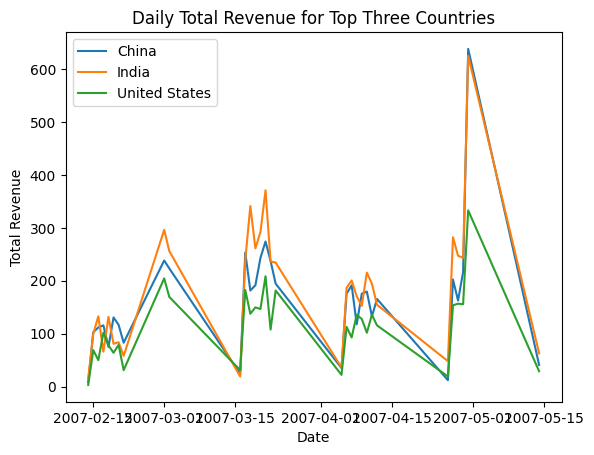

In [59]:
pivot_df.plot()
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.title('Daily Total Revenue for Top Three Countries')
plt.legend()
plt.show()

## 2. Carry out a sentiment analysis on movie descriptions adding another column to the data frame that provides a sentiment classification. This can be based on a “rules based system” that you coded OR inference from a LLM such as using the API for chatgpt.

In [4]:
from transformers import pipeline
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")

In [29]:
conn = psycopg2.connect(
    database="DVD database",
    user="postgres",
    password="thomas612",
    host="127.0.0.1",
    port="5432"
)

df = pd.DataFrame(pd.read_sql_query(
    'SELECT film_id, description '
    'FROM film ',
    conn))

C:\Users\lamma\AppData\Roaming\Python\Python39\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [30]:
# Assuming your DataFrame is named df
descriptions = df['description'].tolist()

# Initialize the sentiment analysis pipeline
sentiment_classifier = pipeline('sentiment-analysis')

# Perform sentiment analysis on descriptions
results = sentiment_classifier(descriptions)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [31]:
descriptions = df['description'].tolist()  # Assuming you have the 'description' column in your DataFrame

df = pd.DataFrame(results)
df['description'] = descriptions

In [32]:
df

,label,score,description
0,POSITIVE,0.995852,A Fateful Reflection of a Moose And a Husband ...
1,POSITIVE,0.999301,A Epic Drama of a Cat And a Explorer who must ...
2,POSITIVE,0.999160,A Epic Tale of a Moose And a Girl who must Con...
3,POSITIVE,0.997738,A Fateful Yarn of a Lumberjack And a Feminist ...
4,POSITIVE,0.999409,A Epic Drama of a Feminist And a Mad Scientist...
...,...,...,...
995,NEGATIVE,0.734137,A Unbelieveable Yarn of a Boat And a Database ...
996,POSITIVE,0.999794,A Touching Drama of a Teacher And a Cat who mu...
997,POSITIVE,0.999200,A Fateful Yarn of a Composer And a Man who mus...
998,POSITIVE,0.986784,A Fateful Reflection of a Waitress And a Boat ...


## 3. Create a visual in the notebook that shows how much revenue is coming from different countries to the DVD store (you will want matplotlib).

In [60]:
grouped_df = df.groupby('country')['sales_amount'].sum().reset_index()

In [68]:
sorted_df = grouped_df.sort_values('sales_amount', ascending=False)

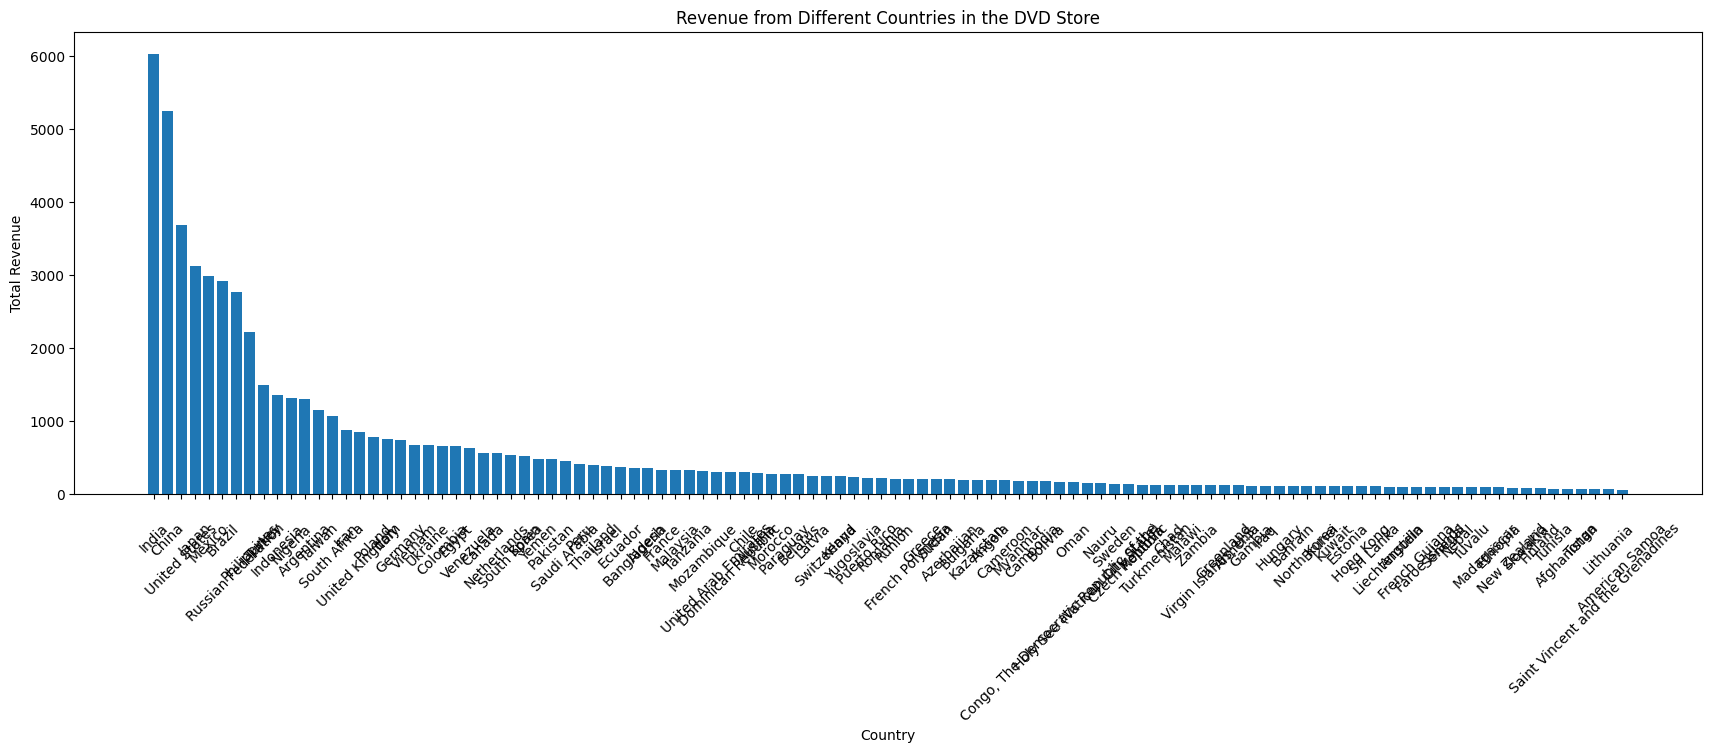

In [73]:
plt.figure(figsize=(21, 6))  # Adjust the figure size as per your preference
plt.bar(sorted_df['country'], sorted_df['sales_amount'])
plt.xlabel('Country')
plt.ylabel('Total Revenue')
plt.title('Revenue from Different Countries in the DVD Store')
plt.xticks(rotation=45)
plt.gca().xaxis.set_tick_params(pad=16)  # Increase the separation between xticks
plt.show()

## 4. Do an analysis to show which actors are bringing in the most revenue (top 10 ranked)

In [83]:
df = pd.DataFrame(pd.read_sql_query(
        "SELECT a.first_name || ' ' || a.last_name AS full_name, AVG(f.rental_rate) AS average_rental_rate "
        'FROM actor a '
        'LEFT JOIN film_actor fa ON a.actor_id = fa.actor_id '
        'LEFT JOIN film f ON fa.film_id = f.film_id '
        'GROUP BY full_name '
        'ORDER BY average_rental_rate DESC ',
    conn))

C:\Users\lamma\AppData\Roaming\Python\Python39\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [85]:
df.head(10)

,full_name,average_rental_rate
0,Gene Hopkins,3.808182
1,Chris Depp,3.790000
2,Fay Kilmer,3.790000
3,Bette Nicholson,3.690000
4,Matthew Johansson,3.690000
5,Dan Torn,3.626364
6,Julia Zellweger,3.615000
7,Ed Mansfield,3.615000
8,Geoffrey Heston,3.605385
9,Chris Bridges,3.582593


## 5.Create a new data-frame where you classify some different countries into some categories that make sense to you (8 countries min, 20 max) in this df there will be two columns, one column will give the country name, the other column will give the classification category.


In [123]:
df = pd.DataFrame(pd.read_sql_query(
    'SELECT '
    'cy.country, '
    'SUM(p.amount) as sales_amount, '
    'DATE(p.payment_date) as payment_date '
    'FROM payment p '
    'LEFT JOIN customer c ON p.customer_id = c.customer_id '
    'LEFT JOIN address a ON a.address_id = c.address_id '
    'LEFT JOIN city ct ON ct.city_id = a.city_id '
    'LEFT JOIN country cy ON cy.country_id = ct.country_id '
    'GROUP BY cy.country, p.amount, DATE(p.payment_date) '
    'ORDER BY DATE(p.payment_date) ASC;',
    conn))

C:\Users\lamma\AppData\Roaming\Python\Python39\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [125]:
# Assuming your original DataFrame is named df
# Group the sales amount by country and calculate the sum
grouped_df = df.groupby('country')['sales_amount'].sum().reset_index()

# Calculate the threshold for the top 20% percentile
threshold = grouped_df['sales_amount'].quantile(0.9)

# Create a new DataFrame with 'country' and boolean column
new_df = pd.DataFrame({'country': grouped_df['country'], 'top_10_percentile': grouped_df['sales_amount'] >= threshold})

# Drop rows where 'top_20_percentile' is False
new_df = new_df.drop(new_df[new_df['top_10_percentile'] == False].index)

# Display the updated DataFrame
new_df

,country,top_10_percentile
13,Brazil,True
21,China,True
42,India,True
43,Indonesia,True
48,Japan,True
58,Mexico,True
67,Nigeria,True
73,Philippines,True
78,Russian Federation,True
95,Turkey,True


## 6.Use an appropriate merge to merge that new data-frame from the last step with a dataframe from the dvd db, that gives the countries, so now countries are connected with their classification. (no need to add this table back to the postgresql db, just doing it in the notebook is fine)


In [126]:
df = pd.DataFrame(pd.read_sql_query(
    'SELECT '
    'cy.country, '
    'SUM(p.amount) as sales_amount, '
    'DATE(p.payment_date) as payment_date '
    'FROM payment p '
    'LEFT JOIN customer c ON p.customer_id = c.customer_id '
    'LEFT JOIN address a ON a.address_id = c.address_id '
    'LEFT JOIN city ct ON ct.city_id = a.city_id '
    'LEFT JOIN country cy ON cy.country_id = ct.country_id '
    'GROUP BY cy.country, p.amount, DATE(p.payment_date) '
    'ORDER BY DATE(p.payment_date) ASC;',
    conn))

C:\Users\lamma\AppData\Roaming\Python\Python39\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [128]:
df

,country,sales_amount,payment_date
0,Austria,2.99,2007-02-14
1,Cambodia,4.99,2007-02-14
2,China,1.99,2007-02-14
3,China,5.98,2007-02-14
4,Egypt,7.99,2007-02-14
...,...,...,...
7270,Vietnam,0.99,2007-05-14
7271,Vietnam,2.99,2007-05-14
7272,Vietnam,4.99,2007-05-14
7273,Yemen,2.99,2007-05-14


In [131]:
merged_df = pd.merge(df, new_df, on='country', how='left').fillna(False)

In [132]:
merged_df

,country,sales_amount,payment_date,top_10_percentile
0,Austria,2.99,2007-02-14,False
1,Cambodia,4.99,2007-02-14,False
2,China,1.99,2007-02-14,True
3,China,5.98,2007-02-14,True
4,Egypt,7.99,2007-02-14,False
...,...,...,...,...
7270,Vietnam,0.99,2007-05-14,False
7271,Vietnam,2.99,2007-05-14,False
7272,Vietnam,4.99,2007-05-14,False
7273,Yemen,2.99,2007-05-14,False
